In [1]:
# Required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from datetime import datetime

#### Data loading & initial processing

In [2]:
# Load the datasets
customers_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\customer_data.csv')
transactions_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\transaction_data.csv')
campaigns_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\campaign_data.csv')
products_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\product_data.csv')
behavioral_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\behavioral_data.csv')

# Convert date columns
date_columns = {
    'transactions_df': ['transaction_date'],
    'campaigns_df': ['start_date', 'end_date'],
    'behavioral_df': ['event_date']
}

for df_name, columns in date_columns.items():
    for col in columns:
        locals()[df_name][col] = pd.to_datetime(locals()[df_name][col])

#### Analysis Framework

##### A. Customer Sagement Analysis: RFM Analysis

In [3]:
def calculate_rfm_metrics(transactions_df, end_date=None):
    """
    Calculate RFM metrics and scores for customer segmentation.
    
    Parameters:
    transactions_df (pd.DataFrame): DataFrame containing columns: 
        customer_id, transaction_date, transaction_id, final_amount
    end_date (datetime, optional): Reference date for recency calculation. 
        Defaults to max transaction date.
    
    Returns:
    pd.DataFrame: DataFrame with RFM metrics and segments
    """
    # Set end_date if not provided
    if end_date is None:
        end_date = transactions_df['transaction_date'].max()
    
    # Calculate base RFM metrics
    rfm = transactions_df.groupby('customer_id').agg({
        'transaction_date': lambda x: (end_date - x.max()).days,  # Recency
        'transaction_id': 'count',  # Frequency
        'final_amount': ['sum', 'mean']  # Monetary (total and average)
    })
    
    # Flatten column names
    rfm.columns = ['recency', 'frequency', 'monetary_total', 'monetary_avg']
    
    # Calculate RFM scores (1-5 scale, 5 being best)
    rfm['R_score'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1])
    rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    rfm['M_score'] = pd.qcut(rfm['monetary_total'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Calculate overall RFM Score
    rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
    
    # Add customer segments
    def segment_customers(row):
        if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
            return 'Champions'
        elif row['R_score'] >= 3 and row['F_score'] >= 3 and row['M_score'] >= 3:
            return 'Loyal Customers'
        elif row['R_score'] >= 4 and row['F_score'] <= 2:
            return 'New Customers'
        elif row['R_score'] <= 2 and row['F_score'] <= 2 and row['M_score'] <= 2:
            return 'Lost Customers'
        elif row['R_score'] >= 3 and row['F_score'] <= 2 and row['M_score'] >= 3:
            return 'Lost Big Spenders'
        else:
            return 'Average Customers'
    
    rfm['customer_segment'] = rfm.apply(segment_customers, axis=1)
    
    return rfm

def analyze_rfm_results(rfm_df):
    """
    Generate summary statistics and insights from RFM analysis.
    """
    summary = {
        'total_customers': len(rfm_df),
        'segment_distribution': rfm_df['customer_segment'].value_counts().to_dict(),
        'avg_metrics_by_segment': rfm_df.groupby('customer_segment').agg({
            'recency': 'mean',
            'frequency': 'mean',
            'monetary_total': 'mean',
            'monetary_avg': 'mean'
        }).round(2).to_dict()
    }
    return summary

# Example usage:
rfm_df = calculate_rfm_metrics(transactions_df)
summary = analyze_rfm_results(rfm_df)

# Print summary
print("Total Customers:", summary['total_customers'])
print("\nCustomer Segment Distribution:")
for segment, count in summary['segment_distribution'].items():
    print(f"{segment}: {count} customers ({(count/summary['total_customers']*100):.1f}%)")

Total Customers: 183757

Customer Segment Distribution:
Average Customers: 63254 customers (34.4%)
Loyal Customers: 35530 customers (19.3%)
Lost Customers: 32188 customers (17.5%)
Champions: 31011 customers (16.9%)
New Customers: 18207 customers (9.9%)
Lost Big Spenders: 3567 customers (1.9%)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8472\2939340891.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=segments, y=counts, palette="coolwarm", edgecolor="black", hue=None)


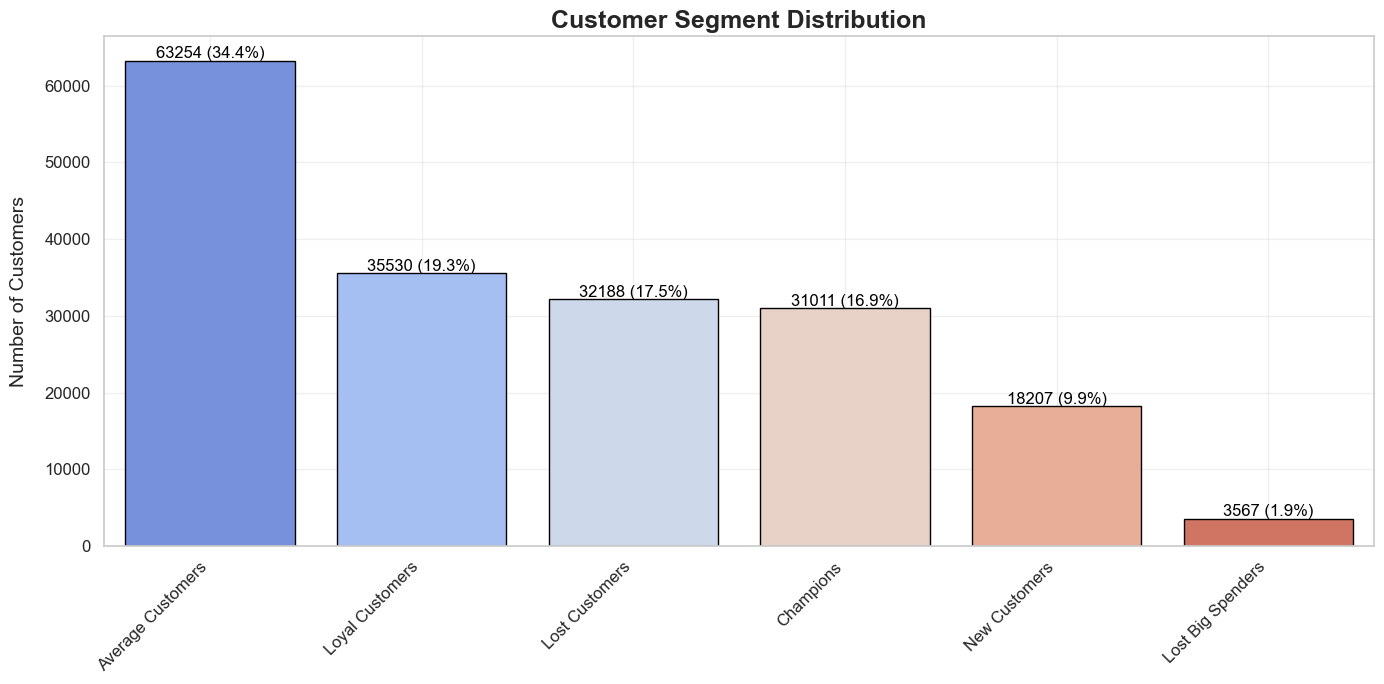

In [27]:
def plot_customer_segment_distribution(segment_distribution):
    
    # Extract segment names and counts
    segments = list(segment_distribution.keys())
    counts = list(segment_distribution.values())
    total_customers = sum(counts)

    # Calculate percentages
    percentages = [count / total_customers * 100 for count in counts]

    # Set seaborn style for aesthetics
    sns.set_theme(style="whitegrid")

    # Create the bar chart
    plt.figure(figsize=(14, 7))
    bars = sns.barplot(x=segments, y=counts, palette="coolwarm", edgecolor="black", hue=None)

    # Add titles and labels
    plt.title('Customer Segment Distribution', fontsize=18, weight='bold')
    plt.ylabel('Number of Customers', fontsize=14, labelpad=12)


    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels above bars
    for bar, count, percentage in zip(bars.patches, counts, percentages):
        height = bar.get_height() + 315
        plt.text(bar.get_x() + bar.get_width() / 2, height + 12, f'{count} ({percentage:.1f}%)',
                 ha='center', fontsize=12, color='black')

    # Make the grid lines more transparent
    plt.grid(visible=True, alpha=0.3)

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

# Assuming you have the `rfm_df` and `summary` from the example usage
rfm_df = calculate_rfm_metrics(transactions_df)
summary = analyze_rfm_results(rfm_df)

# Plot the customer segment distribution
plot_customer_segment_distribution(summary['segment_distribution'])


##### B. Behavioral Segmentation